## Setting up

In [0]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

import Python

let os = Python.import("os")
let plt = Python.import("matplotlib.pyplot")

os.system("git clone https://github.com/mohdsanadzakirizvi/swift-datascience.git")
os.chdir("/content/swift-datascience")

fatal: destination path 'swift-datascience' already exists and is not an empty directory.


None


## Exploring the data

In [0]:
%include "/content/swift-datascience/MNIST.swift"

// Load dataset
let dataset = MNIST(batchSize: 128)

Reading data from files: train-images-idx3-ubyte, train-labels-idx1-ubyte.
Constructing data tensors.
Reading data from files: t10k-images-idx3-ubyte, t10k-labels-idx1-ubyte.
Constructing data tensors.


In [0]:
// Get first 5 images
let imgs = dataset.trainingImages.minibatch(at: 0, batchSize: 5).makeNumpyArray()
print(imgs.shape)

(5, 28, 28, 1)


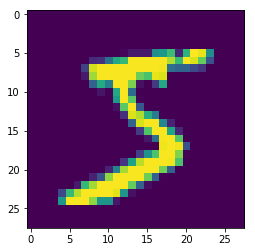

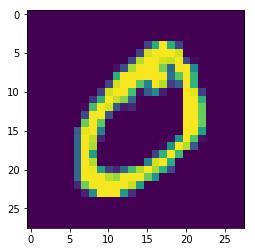

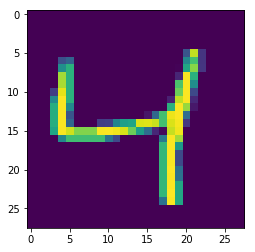

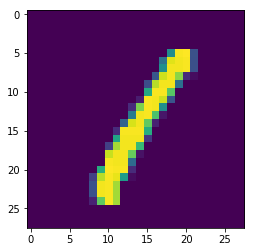

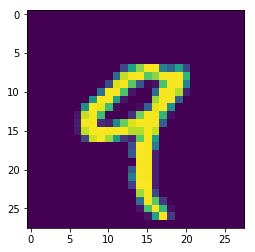

In [0]:
# Display first 5 images
for img in imgs{
  plt.imshow(img.reshape(28,28))
  plt.show()
}

## Model building

In [0]:
import TensorFlow

let epochCount = 100
let batchSize = 128

// The LeNet-5 model
var classifier = Sequential {
    Conv2D<Float>(filterShape: (5, 5, 1, 6), padding: .same, activation: relu)
    AvgPool2D<Float>(poolSize: (2, 2), strides: (2, 2))
    Conv2D<Float>(filterShape: (5, 5, 6, 16), activation: relu)
    AvgPool2D<Float>(poolSize: (2, 2), strides: (2, 2))
    Flatten<Float>()
    Dense<Float>(inputSize: 400, outputSize: 120, activation: relu)
    Dense<Float>(inputSize: 120, outputSize: 84, activation: relu)
    Dense<Float>(inputSize: 84, outputSize: 10, activation: softmax)
}

// Using Gradient Descent as the optimizer
let optimizer = SGD(for: classifier, learningRate: 0.1)

print("Beginning training...")

struct Statistics {
    var correctGuessCount: Int = 0
    var totalGuessCount: Int = 0
    var totalLoss: Float = 0
}

// Store accuracy results during training
var trainAccuracyResults: [Float] = []
var testAccuracyResults: [Float] = []

// The training loop.
for epoch in 1...epochCount {
    var trainStats = Statistics()
    var testStats = Statistics()

    // Set context to training 
    Context.local.learningPhase = .training

    for i in 0 ..< dataset.trainingSize / batchSize {
        // Get mini-batches of x and y
        let x = dataset.trainingImages.minibatch(at: i, batchSize: batchSize)
        let y = dataset.trainingLabels.minibatch(at: i, batchSize: batchSize)
        
        // Compute the gradient with respect to the model.
        let 𝛁model = classifier.gradient { classifier -> Tensor<Float> in
            let ŷ = classifier(x)
            let correctPredictions = ŷ.argmax(squeezingAxis: 1) .== y
            
            trainStats.correctGuessCount += Int(Tensor<Int32>(correctPredictions).sum().scalarized())
            trainStats.totalGuessCount += batchSize
            
            let loss = softmaxCrossEntropy(logits: ŷ, labels: y)
            trainStats.totalLoss += loss.scalarized()
            
            return loss
        }
        
        // Update the model's differentiable variables along the gradient vector.
        optimizer.update(&classifier, along: 𝛁model)
    }

    // Set context to inference
    Context.local.learningPhase = .inference

    for i in 0 ..< dataset.testSize / batchSize {
        let x = dataset.testImages.minibatch(at: i, batchSize: batchSize)
        let y = dataset.testLabels.minibatch(at: i, batchSize: batchSize)

        // Compute loss on test set
        let ŷ = classifier(x)
        let correctPredictions = ŷ.argmax(squeezingAxis: 1) .== y

        testStats.correctGuessCount += Int(Tensor<Int32>(correctPredictions).sum().scalarized())
        testStats.totalGuessCount += batchSize

        let loss = softmaxCrossEntropy(logits: ŷ, labels: y)

        testStats.totalLoss += loss.scalarized()
    }

    let trainAccuracy = Float(trainStats.correctGuessCount) / Float(trainStats.totalGuessCount)
    let testAccuracy = Float(testStats.correctGuessCount) / Float(testStats.totalGuessCount)

    // Save train and test accuracy
    trainAccuracyResults.append(trainAccuracy)
    testAccuracyResults.append(testAccuracy)

    print("""
          [Epoch \(epoch)] \
          Training Loss: \(trainStats.totalLoss), \
          Training Accuracy: \(trainStats.correctGuessCount)/\(trainStats.totalGuessCount) \
          (\(trainAccuracy)), \
          Test Loss: \(testStats.totalLoss), \
          Test Accuracy: \(testStats.correctGuessCount)/\(testStats.totalGuessCount) \
          (\(testAccuracy))
          """)
}

Beginning training...
[Epoch 1] Training Loss: 937.2287, Training Accuracy: 30780/59904 (0.51382214), Test Loss: 134.01508, Test Accuracy: 7443/9984 (0.7454928)
[Epoch 2] Training Loss: 792.0119, Training Accuracy: 46260/59904 (0.7722356), Test Loss: 127.48257, Test Accuracy: 8293/9984 (0.830629)
[Epoch 3] Training Loss: 751.41736, Training Accuracy: 51492/59904 (0.85957533), Test Loss: 120.10599, Test Accuracy: 9242/9984 (0.9256811)
[Epoch 4] Training Loss: 718.39417, Training Accuracy: 55756/59904 (0.93075585), Test Loss: 118.72299, Test Accuracy: 9400/9984 (0.9415064)
[Epoch 5] Training Loss: 710.48395, Training Accuracy: 56686/59904 (0.9462807), Test Loss: 117.73791, Test Accuracy: 9533/9984 (0.9548277)
[Epoch 6] Training Loss: 705.7955, Training Accuracy: 57265/59904 (0.9559462), Test Loss: 117.18693, Test Accuracy: 9597/9984 (0.96123797)
[Epoch 7] Training Loss: 702.90265, Training Accuracy: 57590/59904 (0.96137154), Test Loss: 116.9009, Test Accuracy: 9626/9984 (0.9641426)
[Epoc

: ignored

## Visualizing model training

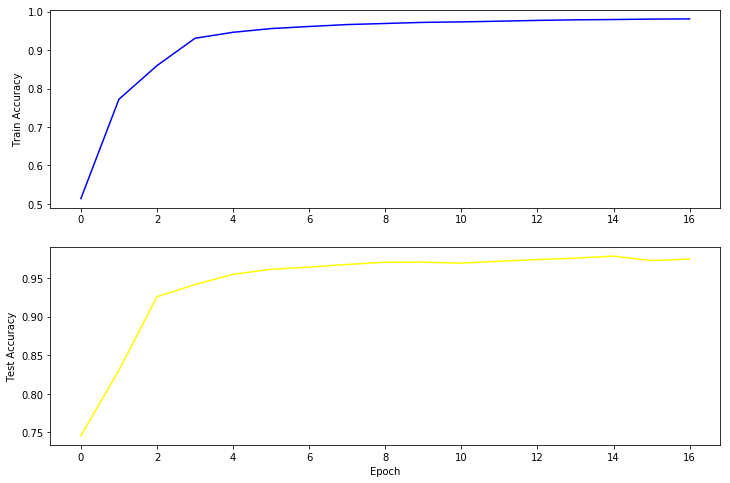

None


In [0]:
plt.figure(figsize: [12, 8])

let accuracyAxes = plt.subplot(2, 1, 1)
accuracyAxes.set_ylabel("Train Accuracy")
accuracyAxes.plot(trainAccuracyResults, color: "blue")

let lossAxes = plt.subplot(2, 1, 2)
lossAxes.set_ylabel("Test Accuracy")
lossAxes.set_xlabel("Epoch")
lossAxes.plot(testAccuracyResults, color: "yellow")

plt.show()